### Imports

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from typing import Any, cast

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from einops import rearrange, repeat
from torchvision.utils import make_grid

from flow_flowers.config import Config
from flow_flowers.data import FlowersDataset, get_transform
from flow_flowers.model import AutoEncoder
from flow_flowers.prob import DatasetSampleable, GaussianSampleable, OTProbPath, ProbPath
from flow_flowers.utils import find_and_chdir, norm2img, set_manual_seed

### Environment

In [13]:
find_and_chdir("config.yaml")
config = Config.init("config.yaml")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_manual_seed(config.base.seed)

In [14]:
# Resize, Crop and Normalize to [-1, 1]
preprocess = get_transform(
    crop=cast(Any, config.data.preprocess.crop),
    size=config.data.preprocess.size,
    norm=True,
)

# Load the Dataset
dataset = FlowersDataset(path=config.data.path, transform=preprocess)

### Reconstruct Images using DeepCompression AutoEncoder

Load AutoEncdoer into GPU

In [15]:
ae = AutoEncoder(id=config.model.autoencoder.id).to(device)

Encode a batch of samples using DC-AE

In [16]:
x_input = rearrange(dataset.sample(8, data="image"), "b c h w -> b c h w")
print("Input Shape: ", x_input.size())

x_latent = ae.encode(x_input.to(device))
print("Latent Shape: ", x_latent.size())

size_input = torch.prod(torch.tensor(x_input.shape[1:]))
size_latent = torch.prod(torch.tensor(x_latent.shape[1:]))
print("Reduction Factor: {:.3}%".format(100 * size_latent / size_input))

Input Shape:  torch.Size([8, 3, 512, 512])
Latent Shape:  torch.Size([8, 32, 16, 16])
Reduction Factor: 1.04%


Decode and measure reconstruction loss

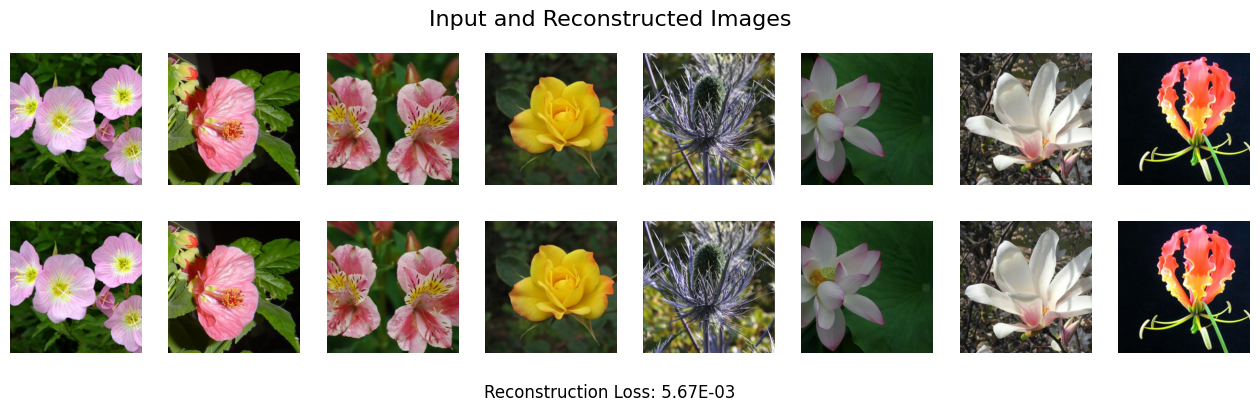

In [17]:
# Latent to Image
x_decode = ae.decode(x_latent).cpu()

# Reconstruction loss
loss = F.mse_loss(x_input, x_decode)

# Map images back to [0.0, 1.0]
x_output = norm2img(x_input)
x_decode = norm2img(x_decode)

# Plot the input and decoded images in two rows using matplotlib
fig, axs = plt.subplots(2, len(x_input), figsize=(len(x_input) * 2, 4))

for i in range(len(x_input)):
    # Permute the tensor from (C, H, W) to (H, W, C) for matplotlib
    axs[0, i].imshow(x_output[i].permute(1, 2, 0))
    axs[0, i].axis("off")

    axs[1, i].imshow(x_decode[i].permute(1, 2, 0))
    axs[1, i].axis("off")

# Add titles to each row
fig.suptitle("Input and Reconstructed Images", fontsize=16)
fig.text(0.5, 0.01, f"Reconstruction Loss: {loss.item():.2E}", ha="center", fontsize=12)
plt.show()

### Compute 

### Sample from the probability path and inspect noise

In [18]:
p_data = DatasetSampleable(device=device, data=dataset, map_entry=lambda x: x[0])
p_init = GaussianSampleable(device=device, size=x_output.shape[1:])
prob_path: ProbPath = OTProbPath(p_init=p_init, p_data=p_data)

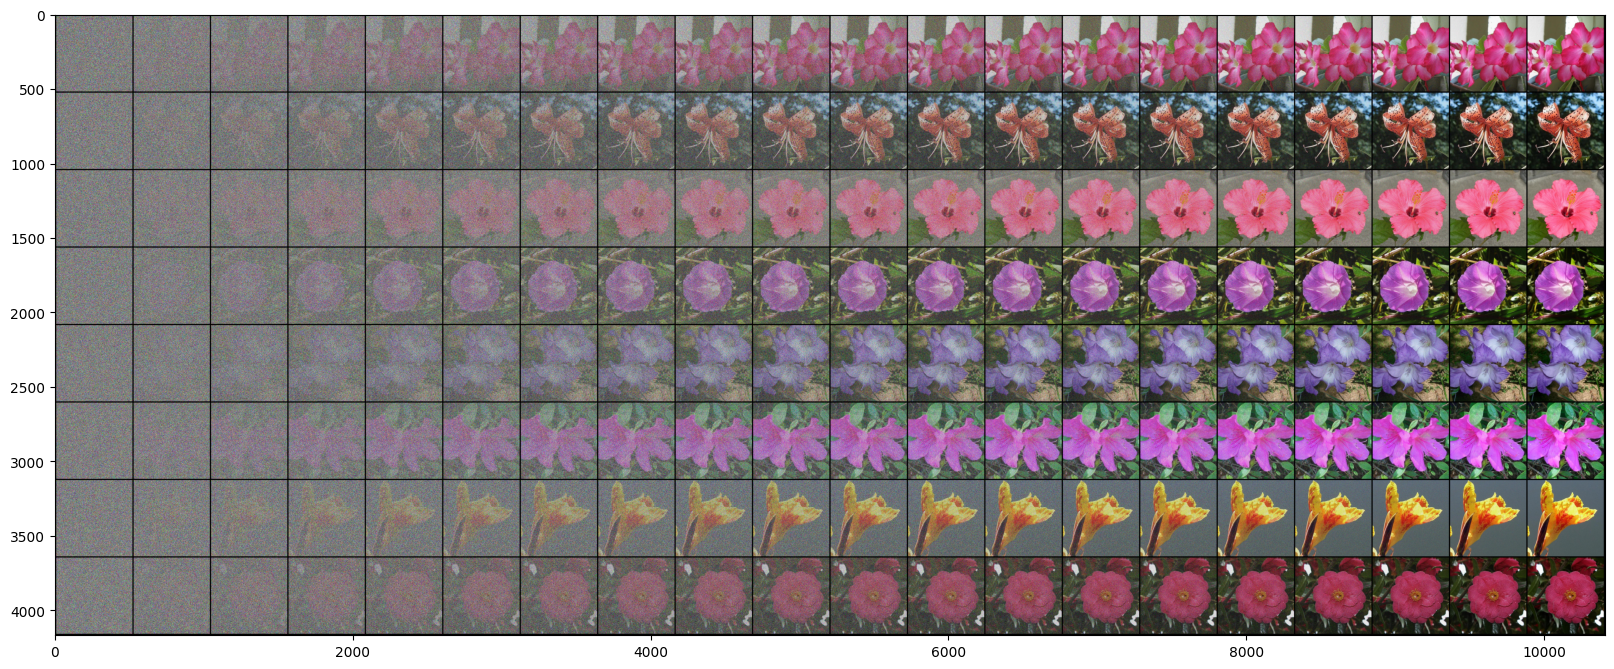

In [37]:
n_samples = 8

t = torch.linspace(0, 1, 20, device=device)
t = repeat(t, "t -> t 1 1 1 1")

x_t = prob_path.marg_prob_path(t=t, n=n_samples)
x_c = x_t
x_t = rearrange(x_t, "t b c h w -> (b t) c h w")
x_t = norm2img(x_t)
x_t = make_grid(x_t, nrow=t.size(0), padding=8)
x_t = rearrange(x_t, "c h w -> h w c")

plt.figure(figsize=(20, 10))
plt.imshow(x_t.cpu())